In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv('Datasets/syntheticDataset_O50.csv') # 데이터 불러오기

df['hour'] = df['request_time'] // 3600  # 초 단위 -> 시간 단위 버킷

object_ids = df['object_ID'].unique()
object_ids.sort()
num_objects = len(object_ids)
print("총 객체 수: ", num_objects)

pivot = df.groupby(['hour', 'object_ID']).size().unstack(fill_value=0)
pivot = pivot.reindex(columns=object_ids, fill_value=0) # 객체 ID 순서 맞추기

# 확률 벡터로 정규화
probs = pivot.div(pivot.sum(axis=1), axis=0).fillna(0)

m, K = 20, 10
X = []
y = []

for i in range(len(probs) - m - K):
  x_seq = probs.iloc[i:i+m].values  # shape: (m, d)
  x_next = probs.iloc[i+m:i+m+K].values
  X.append(x_seq)
  y.append(x_next)

X = np.array(X)
y = np.array(y)

print("X.shape =", X.shape)
print("y.shape =", y.shape)

총 객체 수:  50
X.shape = (55, 20, 50)
y.shape = (55, 10, 50)


In [9]:
# LSTM 예측 모델
# 과거 일정 시간 동안의 요청 분포를 받아서 앞으로의 일정 시간 동안의 요청 분포를 예측하는 구조
# Encoder: 과거 m시간 동안의 요청 분포((m, 1033) 시퀀스)를 받아서, 마지막 hidden state와 cell state로 응축된 정보를 생성 -> context vector로 요약
# Decoder: Encoder에서 받은 context vector를 바탕으로, 앞으로 k시간 동안 어떤 객체들이 얼마나 요청될지를 시퀀스 형태로 한 시간씩 예측
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector

def build_seq2seq_model(m, K, num_objects):
  # ----- Encoder -----
  encoder_inputs = Input(shape=(m, num_objects)) # (batch, m(시간), num_objects(객체수))
  encoder_lstm = LSTM(128, return_state=True) # LSTM이 마지막 시점의 hidden state와 cell state를 반환
  encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) # state_h와 state_c는 Decoder의 초기 상태로 사용됨
  encoder_states = [state_h, state_c] # Encoder의 상태를 Decoder에 전달하기 위해 리스트로 묶음

  # ----- Decoder -----
  decoder_inputs = RepeatVector(K)(encoder_outputs) # (batch, K, 128): Encoder의 마지막 출력을 K번 복제해서 Decoder 입력으로 사용, Decoder는 K시간 동안 예측을 수행
  decoder_lstm = LSTM(128, return_sequences=True) # LSTM의 hidden size는 64, return_sequences=True는 각 시점마다 출력을 반환
  decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)

  # 객체별 확률 예측 (각 시점당 num_objects 개 출력)
  decoder_dense = TimeDistributed(Dense(num_objects, activation='softmax')) # softmax는 확률 분포로 만들어줌
  output_seq = decoder_dense(decoder_outputs)

  # ----- 모델 구성 -----
  model = Model(encoder_inputs, output_seq)
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  return model


num_objects = 50  # 객체 수
m = 20              # 과거 시간: 입력 시퀀스 길이
K = 10             # 미래 시간: 출력 시퀀스 길이

model = build_seq2seq_model(m, K, num_objects)

# 데이터: X shape = (samples, 20, 50), y shape = (samples, 10, 50)
history = model.fit(X, y, epochs=30, batch_size=32, validation_split=0.1)

# 학습 후 추론 코드
from sklearn.model_selection import train_test_split

# 시퀀스 데이터를 학습/검증/테스트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습 시에도 X_train, y_train 사용
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

# 추론 (예측)
y_pred = model.predict(X_test)
print("예측 결과 형태:", y_pred.shape)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 8.2351e-04 - mae: 0.0140 - val_loss: 0.0013 - val_mae: 0.0131
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 8.7885e-04 - mae: 0.0144 - val_loss: 0.0013 - val_mae: 0.0131
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 8.3563e-04 - mae: 0.0141 - val_loss: 0.0013 - val_mae: 0.0130
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 8.4617e-04 - mae: 0.0142 - val_loss: 0.0013 - val_mae: 0.0130
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 8.7884e-04 - mae: 0.0143 - val_loss: 0.0013 - val_mae: 0.0130
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 7.9582e-04 - mae: 0.0138 - val_loss: 0.0013 - val_mae: 0.0130
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 8.3349e-04 - mae: 0.0140 - val_loss: 0.0013 - val_mae: 0.0130
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 8.6588e-04 - mae: 0.0142 - val_loss: 0.0013 - val_mae: 0.0130
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100m

In [10]:
# 캐시 정책 구현
# 예측 결과를 기반으로 DeepCache의 캐싱 정책을 구현하고 이를 통해 기본 캐싱 전략과 비교평가
M = 5 # 캐시에 넣을 상위 M개 객체
top_objects_each_t = []

# 예측 결과에서 Top-M 객체 추출
for i in range(len(y_pred)):
    for t in range(K - 1):    # t+1 예측을 위해 K-1까지만
        next_probs = y_pred[i, t+1]  # 다음 시점 확률 분포
        top_indices = next_probs.argsort()[-M:][::-1]  # 상위 M개 객체 인덱스
        top_objects_each_t.append(top_indices)

# 실제 요청 로그 준비
actual_requests = df.sort_values('request_time')['object_ID'].tolist()

In [14]:
# 캐시 시뮬레이션 (LRU + 예측 기반) -> 성능 평가
from collections import deque

def simulate_deepcache(actual_requests, top_objects_each_t, cache_size=20, insert_interval=100):
  """
    DeepCache 캐시 시뮬레이션을 수행하고 hit ratio를 반환합니다.

    Parameters:
        actual_requests (list): 실제 요청 객체 ID 리스트
        top_objects_each_t (list of lists): 예측된 상위 M개의 객체 리스트 (매 insert_interval마다 1개 list)
        cache_size (int): 캐시 크기
        insert_interval (int): 예측 객체를 캐시에 넣는 주기 (예: 100 step마다 예측 사용)

    Returns:
        hit_ratio (float): 캐시 hit 비율
  """

  cache = deque(maxlen=cache_size)
  hit = 0
  total = 0
  fake_insert_idx = 0

  for t, req in enumerate(actual_requests):
    # 예측한 객체를 먼저 캐시에 넣기
    if t % insert_interval == 0 and fake_insert_idx < len(top_objects_each_t):
      fake_objs = top_objects_each_t[fake_insert_idx]
      for obj in fake_objs:
        if obj not in cache:
          cache.append(obj)
      fake_insert_idx += 1

    total += 1
    if req in cache:
      hit += 1
    else:
      cache.append(req)

  hit_ratio = hit / total if total > 0 else 0
  return hit_ratio

deepcache_hit = simulate_deepcache(actual_requests, top_objects_each_t, cache_size=20, insert_interval=100)
print(f"DeepCache 기반 캐시 hit ratio: {deepcache_hit:.4f}")

DeepCache 기반 캐시 hit ratio: 0.6571


In [15]:
# 기본 LRU 캐시와 성능 비교
# LRU 캐시 시뮬레이터 코드
from collections import OrderedDict

class LRUCache:
  def __init__(self, capacity):
    self.capacity = capacity
    self.cache = OrderedDict()
    self.hit = 0
    self.miss = 0

  def request(self, obj_id):
    if obj_id in self.cache:
      self.cache.move_to_end(obj_id)
      self.hit += 1
    else:
      self.miss += 1
      if len(self.cache) >= self.capacity:
        self.cache.popitem(last=False) # 길이를 넘으면 pop
      self.cache[obj_id] = True # 최근 것 push

  def get_hit_ratio(self):
    total = self.hit + self.miss
    return self.hit / total if total > 0 else 0

In [16]:
# 요청 로그를 읽어서 LRU 시뮬레이션 수행
import pandas as pd

df = pd.read_csv('Datasets/syntheticDataset_O50.csv')
requests = df['object_ID'].tolist()

cache_size = 5
lru = LRUCache(cache_size)

for obj_id in requests:
  lru.request(obj_id)

print("LRU 캐시 hit ratio:", round(lru.get_hit_ratio(), 4))

LRU 캐시 hit ratio: 0.3021


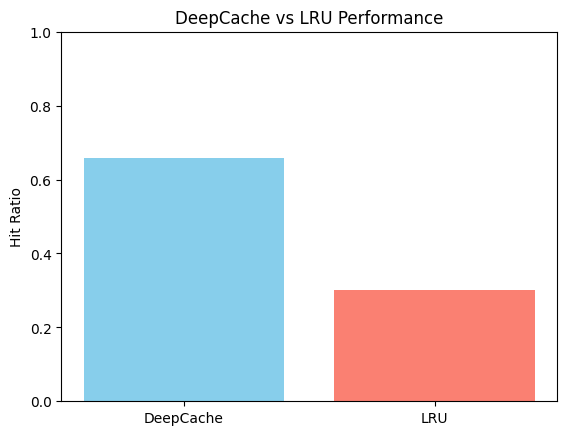

In [18]:
# 비교 결과 시각화
import matplotlib.pyplot as plt

ratios = [
    simulate_deepcache(actual_requests, top_objects_each_t, cache_size=20, insert_interval=100),  # DeepCache
    lru.get_hit_ratio()  # 기존 LRU 객체에서 hit ratio 가져오기
]
labels = ['DeepCache', 'LRU']

plt.bar(labels, ratios, color=['skyblue', 'salmon'])
plt.ylabel('Hit Ratio')
plt.title('DeepCache vs LRU Performance')
plt.ylim(0, 1)
plt.show()